# Not

Bu notebook proje boyunca yaptığımız denemelerin ham halidir.

Daha net ve gereksiz kodlardan arındırılmış akış için şu notebook'u kullan:
- `02_scarf_rul_best_clean.ipynb`

Orada:
- unit bazlı split + train-only scaling (leakage yok)
- best ayarlar (ws=50, cr=0.6, temp=0.1, lr_encoder=1e-4, rul_cap=125)
- SCARF pretrain + kademeli fine-tune
- RMSE/MAE + basit görselleştirme


In [2]:
# --- Temel kütüphaneler ---
import os                       # klasör/dosya kontrolü için
import numpy as np              # sayısal işlemler / array
import pandas as pd             # tablo (DataFrame) işlemleri

# --- Ön işleme ---
from sklearn.preprocessing import MinMaxScaler  # 0-1 ölçekleme

# --- Derin öğrenme ---
import torch                    # SCARF corruption ve sonraki adımda encoder için

# --- Mini kontrol: ortam doğru mu? ---
print("Working dir:", os.getcwd())
print("numpy:", np.__version__)
print("pandas:", pd.__version__)
print("torch:", torch.__version__)
print("cuda available?:", torch.cuda.is_available())  # False olması sorun değil (CPU yeter)


Working dir: /Users/elifcinar/Desktop/rul_scarf
numpy: 2.3.5
pandas: 2.3.3
torch: 2.5.1
cuda available?: False


In [3]:
# CMAPSS dosyası notebook ile aynı klasörde olmalı.
DATA_PATH = "train_FD001.txt"

print("File exists?", os.path.exists(DATA_PATH))

# CMAPSS dosyasında kolon isimleri yazmaz, biz tanımlarız:
# unit_nr: motor kimliği
# time_cycles: zaman/cycle indeksi
index_names = ["unit_nr", "time_cycles"]

# Operating settings (FD001 genelde sabit ama yine de veri içinde var)
setting_names = ["setting_1", "setting_2", "setting_3"]

# 21 sensör: s_1 ... s_21
sensor_names = [f"s_{i}" for i in range(1, 22)]

col_names = index_names + setting_names + sensor_names

# Dosya boşluklarla ayrılmıştır (multiple spaces). Regex ile ayırıyoruz.
df_raw = pd.read_csv(DATA_PATH, sep=r"\s+", header=None, names=col_names)

print("df_raw shape:", df_raw.shape)   # (satır sayısı, kolon sayısı) beklenir: ~ (20k+, 26)
df_raw.head()


File exists? True
df_raw shape: (20631, 26)


,unit_nr,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [4]:
# Sabit kolon = hiç değişmeyen kolon (varyansı 0) => bilgi taşımaz.
# numeric_only=True: sadece sayısal kolonlarda hesap yap
variances = df_raw.var(numeric_only=True)

constant_cols = variances[variances == 0].index.tolist()

print("Constant columns (variance=0):", constant_cols)
print("Count:", len(constant_cols))


Constant columns (variance=0): ['setting_3', 's_18', 's_19']
Count: 3


In [5]:
df = df_raw.copy()

# unit_nr ve time_cycles asla drop etmiyoruz (pencereleme için lazım)
cols_to_drop = [c for c in constant_cols if c not in ["unit_nr", "time_cycles"]]

df.drop(columns=cols_to_drop, inplace=True)

# Modelin göreceği feature'lar (kimlik ve zaman hariç her şey)
feature_cols = [c for c in df.columns if c not in ["unit_nr", "time_cycles"]]

print("After dropping constants:", df.shape)
print("Feature count:", len(feature_cols))
print("First few features:", feature_cols[:10])


After dropping constants: (20631, 23)
Feature count: 21
First few features: ['setting_1', 'setting_2', 's_1', 's_2', 's_3', 's_4', 's_5', 's_6', 's_7', 's_8']


In [6]:
# Neden?
# Sensörlerin ölçekleri farklı olabilir -> model büyük değerli sensöre aşırı odaklanır.
# 0-1 scaling öğrenmeyi stabil yapar.

scaler = MinMaxScaler()
df[feature_cols] = scaler.fit_transform(df[feature_cols])

df.head()


,unit_nr,time_cycles,setting_1,setting_2,s_1,s_2,s_3,s_4,s_5,s_6,...,s_10,s_11,s_12,s_13,s_14,s_15,s_16,s_17,s_20,s_21
0,1,1,0.459770,0.166667,0.0,0.183735,0.406802,0.309757,0.0,1.0,...,0.0,0.369048,0.633262,0.205882,0.199608,0.363986,0.0,0.333333,0.713178,0.724662
1,1,2,0.609195,0.250000,0.0,0.283133,0.453019,0.352633,0.0,1.0,...,0.0,0.380952,0.765458,0.279412,0.162813,0.411312,0.0,0.333333,0.666667,0.731014
2,1,3,0.252874,0.750000,0.0,0.343373,0.369523,0.370527,0.0,1.0,...,0.0,0.250000,0.795309,0.220588,0.171793,0.357445,0.0,0.166667,0.627907,0.621375
3,1,4,0.540230,0.500000,0.0,0.343373,0.256159,0.331195,0.0,1.0,...,0.0,0.166667,0.889126,0.294118,0.174889,0.166603,0.0,0.333333,0.573643,0.662386
4,1,5,0.390805,0.333333,0.0,0.349398,0.257467,0.404625,0.0,1.0,...,0.0,0.255952,0.746269,0.235294,0.174734,0.402078,0.0,0.416667,0.589147,0.704502


In [7]:
def create_windows(data: pd.DataFrame, feature_cols, window_size=30):
    """
    Amaç:
    Her motor için zaman serisini gezip,
    her 'window_size' uzunluktaki parçayı tek satır vektör yap (flatten).

    Örn:
    feature_count = 17, window_size = 30 ise:
    bir pencere: (30, 17) -> flatten -> (510,) tek satır
    """

    X = []      # model girdileri (her biri 1 uzun vektör)
    meta = []   # hangi motor + hangi cycle aralığı (takip için)

    # Her motoru ayrı ayrı işleriz (karışmasın)
    for unit_id in data["unit_nr"].unique():

        # Bu motora ait satırlar + zaman sırası garantisi
        unit_df = data[data["unit_nr"] == unit_id].sort_values("time_cycles")

        # Sadece feature kolonlarını alıyoruz (unit/time model girdisi değil)
        values = unit_df[feature_cols].values          # shape: (T, feature_count)
        cycles = unit_df["time_cycles"].values         # shape: (T,)

        # Eğer yeterli uzunluk yoksa pencere çıkmaz
        if len(values) < window_size:
            continue

        # Kayar pencere:
        # Toplam pencere sayısı: T - window_size + 1
        for i in range(len(values) - window_size + 1):

            # Pencere matrisi: (window_size, feature_count)
            window_matrix = values[i:i+window_size]

            # Flatten: satır satır tek vektör (window_size*feature_count,)
            window_vec = window_matrix.flatten()

            X.append(window_vec)

            # meta: bu pencerenin motoru ve cycle aralığı
            meta.append((unit_id, cycles[i], cycles[i+window_size-1]))

    # Liste -> numpy array (model için daha uygun)
    X = np.array(X, dtype=np.float32)

    # meta -> DataFrame (kolay kontrol ve görselleştirme için)
    meta = pd.DataFrame(meta, columns=["unit_nr", "start_cycle", "end_cycle"])

    return X, meta


In [8]:
WINDOW_SIZE = 30

X_train, meta_train = create_windows(df, feature_cols, window_size=WINDOW_SIZE)

print("X_train shape:", X_train.shape)
print("meta_train shape:", meta_train.shape)

# Mantık kontrol:
# X_train ikinci boyut = 30 * feature_count olmalı
print("Expected feature dim:", WINDOW_SIZE * len(feature_cols))

meta_train.head()


X_train shape: (17731, 630)
meta_train shape: (17731, 3)
Expected feature dim: 630


,unit_nr,start_cycle,end_cycle
0,1,1,30
1,1,2,31
2,1,3,32
3,1,4,33
4,1,5,34


In [9]:
def scarf_corrupt(x: torch.Tensor, corruption_rate=0.6):
    """
    SCARF corruption:
    - x: (batch, feature_dim)
    - mask ile feature'ların belirli bir yüzdesini seç
    - seçilen hücreleri batch'ten karıştırılmış başka örnekten al

    Neden iyi?
    - Rastgele gürültü yerine 'gerçek veri dağılımından' değer almış oluyorsun.
    - Tabular veride çok mantıklı bir augmentation.
    """

    batch_size, feature_dim = x.shape

    # Hangi hücreler bozulacak? True olanlar değişecek.
    mask = torch.rand(batch_size, feature_dim, device=x.device) < corruption_rate

    # Batch'i karıştır: başka örnekten değer çekmek için kaynak
    x_perm = x[torch.randperm(batch_size, device=x.device)]

    # Bozulmuş kopya üret
    x_tilde = x.clone()
    x_tilde[mask] = x_perm[mask]

    return x_tilde


In [10]:
# Küçük bir batch al
xb = torch.tensor(X_train[:8])

# Bozulmuş halini üret
xb_tilde = scarf_corrupt(xb, corruption_rate=0.6)

print("xb shape:", xb.shape)
print("xb_tilde shape:", xb_tilde.shape)

# Kaç hücre değişmiş? ~0.6 beklenir.
changed_ratio = (xb != xb_tilde).float().mean().item()
print("Changed ratio:", changed_ratio)


xb shape: torch.Size([8, 630])
xb_tilde shape: torch.Size([8, 630])
Changed ratio: 0.4386904835700989


In [11]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# Neden DataLoader?
# - Pretraining sırasında veriyi batch batch besleyeceğiz.
# - InfoNCE loss için batch içi negatif örnekler gerekiyor.

# X_train numpy -> torch tensor
X_tensor = torch.tensor(X_train, dtype=torch.float32)

dataset = TensorDataset(X_tensor)

BATCH_SIZE = 256   # Mac CPU'da 128/256 iyi başlar. RAM yetmezse 128 yap.
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

print("Total samples:", len(dataset))
print("Batches per epoch:", len(loader))


Total samples: 17731
Batches per epoch: 69


In [12]:
import torch.nn as nn
import torch.nn.functional as F

class MLPEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim=256, emb_dim=64, proj_dim=64, dropout=0.1):
        super().__init__()

        # Encoder: input -> emb (asıl "sağlık vektörü" burada)
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),

            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),

            nn.Linear(hidden_dim, emb_dim)
        )

        # Projection head: emb -> proj (InfoNCE için)
        self.projector = nn.Sequential(
            nn.Linear(emb_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, proj_dim)
        )

    def forward(self, x):
        # x: (batch, input_dim)
        h = self.encoder(x)          # (batch, emb_dim)
        z = self.projector(h)        # (batch, proj_dim)
        # Kontrastif öğrenmede genelde normalize ederiz (cosine similarity gibi düşün)
        z = F.normalize(z, dim=1)
        return h, z


# input_dim = her satırın boyutu
input_dim = X_train.shape[1]
model = MLPEncoder(input_dim=input_dim, hidden_dim=256, emb_dim=64, proj_dim=64, dropout=0.1)

print("Input dim:", input_dim)
print(model)


Input dim: 630
MLPEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=630, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=256, out_features=256, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=256, out_features=64, bias=True)
  )
  (projector): Sequential(
    (0): Linear(in_features=64, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=64, bias=True)
  )
)


In [13]:
def info_nce_loss(z, z_tilde, temperature=0.1):
    """
    z:       (batch, proj_dim)  -> normalize edilmiş
    z_tilde: (batch, proj_dim)  -> normalize edilmiş

    Logit matrisi: z @ z_tilde^T  -> (batch, batch)
    Doğru eşleşme i -> i (diagonal)
    """
    # Benzerlik (cosine'a çok benzer çünkü normalize ettik)
    logits = (z @ z_tilde.T) / temperature   # (B, B)

    # Doğru etiketler: her satırın doğru sınıfı kendi index'i
    labels = torch.arange(z.size(0), device=z.device)

    # Cross entropy: her z_i, z_tilde içinde doğru eşini seçsin
    loss = F.cross_entropy(logits, labels)
    return loss


In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

LR = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-5)

TEMPERATURE = 0.1
CORRUPTION_RATE = 0.6
EPOCHS = 20   # hızlı deneme için 10, daha iyi temsil için 30-50 deneyebilirsin

print("Device:", device)


Device: cpu


In [15]:
loss_history = []

model.train()
for epoch in range(1, EPOCHS + 1):
    epoch_loss = 0.0

    for (xb,) in loader:
        xb = xb.to(device)  # (batch, input_dim)

        # 1) Bozulmuş kopya üret
        xb_tilde = scarf_corrupt(xb, corruption_rate=CORRUPTION_RATE)

        # 2) Embedding üret (h: temsil, z: projeksiyon)
        _, z = model(xb)
        _, z_tilde = model(xb_tilde)

        # 3) InfoNCE
        loss = info_nce_loss(z, z_tilde, temperature=TEMPERATURE)

        # 4) Geri yayılım
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(loader)
    loss_history.append(avg_loss)

    print(f"Epoch {epoch:02d}/{EPOCHS} | loss: {avg_loss:.4f}")


Epoch 01/20 | loss: 5.2942
Epoch 02/20 | loss: 5.2290
Epoch 03/20 | loss: 5.2254
Epoch 04/20 | loss: 5.2157
Epoch 05/20 | loss: 5.2088
Epoch 06/20 | loss: 5.2004
Epoch 07/20 | loss: 5.2042
Epoch 08/20 | loss: 5.1943
Epoch 09/20 | loss: 5.1900
Epoch 10/20 | loss: 5.1896
Epoch 11/20 | loss: 5.1990
Epoch 12/20 | loss: 5.1899
Epoch 13/20 | loss: 5.1924
Epoch 14/20 | loss: 5.1843
Epoch 15/20 | loss: 5.1833
Epoch 16/20 | loss: 5.1782
Epoch 17/20 | loss: 5.1864
Epoch 18/20 | loss: 5.1745
Epoch 19/20 | loss: 5.1789
Epoch 20/20 | loss: 5.1752


In [16]:
# Encoder+projector birlikte kaydediyoruz
torch.save(model.state_dict(), "scarf_pretrained.pt")
print("Saved:", "scarf_pretrained.pt")


Saved: scarf_pretrained.pt


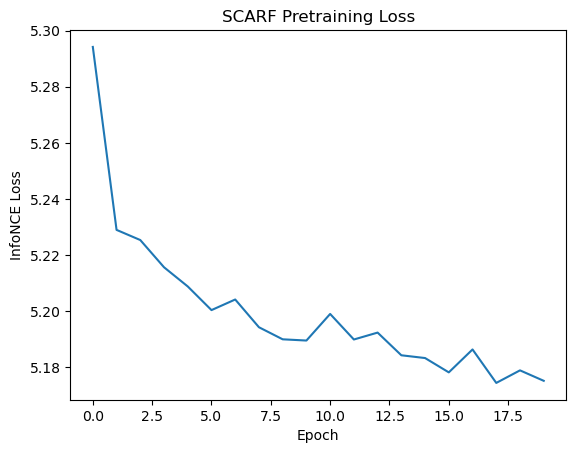

In [17]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(loss_history)
plt.xlabel("Epoch")
plt.ylabel("InfoNCE Loss")
plt.title("SCARF Pretraining Loss")
plt.show()


In [18]:
# df: normalize edilmiş ve constant drop yapılmış DataFrame (Day-1)
# meta_train: (unit_nr, start_cycle, end_cycle) DataFrame (Day-1)

# Her motorun veri setindeki son cycle'ı
max_cycle_per_unit = df.groupby("unit_nr")["time_cycles"].max()

print(max_cycle_per_unit.head())
print("Total units:", max_cycle_per_unit.shape[0])


unit_nr
1    192
2    287
3    179
4    189
5    269
Name: time_cycles, dtype: int64
Total units: 100


In [19]:
# meta_train içindeki unit ve end_cycle bilgisi ile RUL hesaplıyoruz
# RUL = max_cycle(unit) - end_cycle(window)

# unit_nr -> max_cycle eşlemesi
meta_train = meta_train.copy()
meta_train["max_cycle"] = meta_train["unit_nr"].map(max_cycle_per_unit)

# RUL hesabı
meta_train["RUL"] = meta_train["max_cycle"] - meta_train["end_cycle"]

# Kontrol
meta_train[["unit_nr","start_cycle","end_cycle","max_cycle","RUL"]].head()


,unit_nr,start_cycle,end_cycle,max_cycle,RUL
0,1,1,30,192,162
1,1,2,31,192,161
2,1,3,32,192,160
3,1,4,33,192,159
4,1,5,34,192,158


In [20]:
# İstersen aç: bazı çalışmalarda RUL'u 125/130 gibi bir değerde sınırlarlar.
RUL_CAP = None  # örn: 125 yapmak istersen 125 yaz

if RUL_CAP is not None:
    meta_train["RUL"] = meta_train["RUL"].clip(upper=RUL_CAP)

meta_train["RUL"].describe()


count    17731.000000
mean        94.150640
std         61.922692
min          0.000000
25%         44.000000
50%         88.000000
75%        135.000000
max        332.000000
Name: RUL, dtype: float64

In [21]:
from sklearn.model_selection import train_test_split

units = meta_train["unit_nr"].unique()
train_units, val_units = train_test_split(units, test_size=0.2, random_state=42)

train_mask = meta_train["unit_nr"].isin(train_units)
val_mask   = meta_train["unit_nr"].isin(val_units)

X_tr = X_train[train_mask.values]
y_tr = meta_train.loc[train_mask, "RUL"].values.astype(np.float32)

X_va = X_train[val_mask.values]
y_va = meta_train.loc[val_mask, "RUL"].values.astype(np.float32)

print("Train:", X_tr.shape, y_tr.shape)
print("Val:",   X_va.shape, y_va.shape)


Train: (14241, 630) (14241,)
Val: (3490, 630) (3490,)


In [22]:
import torch
from torch.utils.data import TensorDataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Xtr_t = torch.tensor(X_tr, dtype=torch.float32)
ytr_t = torch.tensor(y_tr, dtype=torch.float32)

Xva_t = torch.tensor(X_va, dtype=torch.float32)
yva_t = torch.tensor(y_va, dtype=torch.float32)

train_loader = DataLoader(TensorDataset(Xtr_t, ytr_t), batch_size=256, shuffle=True)
val_loader   = DataLoader(TensorDataset(Xva_t, yva_t), batch_size=256, shuffle=False)

print("Device:", device)


Device: cpu


In [24]:
import torch
import torch.nn as nn
import math
from torch.utils.data import TensorDataset, DataLoader

class RULRegressor(nn.Module):
    """
    Pretrained encoder'dan çıkan sağlık vektörünü (h) alır
    ve bunu küçük bir regresyon başlığıyla (head) RUL değerine map eder.
    """
    def __init__(self, pretrained_encoder, emb_dim=64):
        super().__init__()
        self.encoder = pretrained_encoder

        # Küçük regression head (basit tutuyoruz ki temsil bilgisi bozulmasın)
        self.head = nn.Sequential(
            nn.Linear(emb_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        # Encoder forward: h temsil, z projeksiyon (z burada gerekmiyor)
        h, _ = self.encoder(x)              # h: (batch, emb_dim)
        yhat = self.head(h).squeeze(1)      # (batch,)
        return yhat


# Modeli kur
reg_model = RULRegressor(model, emb_dim=64).to(device)

# Kontrol: gerçekten sadece head mi trainable?
trainable = [(n, p.numel()) for n, p in reg_model.named_parameters() if p.requires_grad]
print("Trainable parameters:", trainable[:6], "...")
print("Trainable param count:", sum(p.numel() for p in reg_model.parameters() if p.requires_grad))


Trainable parameters: [('encoder.projector.0.weight', 16384), ('encoder.projector.0.bias', 256), ('encoder.projector.2.weight', 16384), ('encoder.projector.2.bias', 64), ('head.0.weight', 4096), ('head.0.bias', 64)] ...
Trainable param count: 37313


In [25]:
# Numpy -> Torch
Xtr_t = torch.tensor(X_tr, dtype=torch.float32)
ytr_t = torch.tensor(y_tr, dtype=torch.float32)

Xva_t = torch.tensor(X_va, dtype=torch.float32)
yva_t = torch.tensor(y_va, dtype=torch.float32)

train_loader = DataLoader(TensorDataset(Xtr_t, ytr_t), batch_size=256, shuffle=True)
val_loader   = DataLoader(TensorDataset(Xva_t, yva_t), batch_size=256, shuffle=False)

print("Train batches:", len(train_loader))
print("Val batches:", len(val_loader))


Train batches: 56
Val batches: 14


In [26]:
criterion = nn.MSELoss()

# Encoder frozen olduğu için sadece head'i optimize ediyoruz
optimizer = torch.optim.Adam(reg_model.head.parameters(), lr=1e-3)

EPOCHS_FT = 20

for epoch in range(1, EPOCHS_FT + 1):

    # ----- TRAIN -----
    reg_model.train()
    train_mse_sum = 0.0

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)

        yhat = reg_model(xb)
        loss = criterion(yhat, yb)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_mse_sum += loss.item()

    train_mse = train_mse_sum / len(train_loader)
    train_rmse = math.sqrt(train_mse)

    # ----- VAL -----
    reg_model.eval()
    val_mse_sum = 0.0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            yhat = reg_model(xb)
            val_mse_sum += criterion(yhat, yb).item()

    val_mse = val_mse_sum / len(val_loader)
    val_rmse = math.sqrt(val_mse)

    print(f"Epoch {epoch:02d}/{EPOCHS_FT} | Train RMSE: {train_rmse:.2f} | Val RMSE: {val_rmse:.2f}")


Epoch 01/20 | Train RMSE: 113.27 | Val RMSE: 106.55
Epoch 02/20 | Train RMSE: 111.68 | Val RMSE: 104.26
Epoch 03/20 | Train RMSE: 108.80 | Val RMSE: 100.41
Epoch 04/20 | Train RMSE: 104.20 | Val RMSE: 95.17
Epoch 05/20 | Train RMSE: 98.57 | Val RMSE: 88.85
Epoch 06/20 | Train RMSE: 91.95 | Val RMSE: 81.67
Epoch 07/20 | Train RMSE: 84.88 | Val RMSE: 73.97
Epoch 08/20 | Train RMSE: 77.34 | Val RMSE: 65.97
Epoch 09/20 | Train RMSE: 69.84 | Val RMSE: 58.17
Epoch 10/20 | Train RMSE: 62.97 | Val RMSE: 51.13
Epoch 11/20 | Train RMSE: 56.94 | Val RMSE: 45.04
Epoch 12/20 | Train RMSE: 52.02 | Val RMSE: 40.17
Epoch 13/20 | Train RMSE: 48.30 | Val RMSE: 36.70
Epoch 14/20 | Train RMSE: 45.84 | Val RMSE: 34.39
Epoch 15/20 | Train RMSE: 44.19 | Val RMSE: 32.98
Epoch 16/20 | Train RMSE: 43.25 | Val RMSE: 32.16
Epoch 17/20 | Train RMSE: 42.65 | Val RMSE: 31.71
Epoch 18/20 | Train RMSE: 42.31 | Val RMSE: 31.45
Epoch 19/20 | Train RMSE: 42.02 | Val RMSE: 31.28
Epoch 20/20 | Train RMSE: 41.81 | Val RMSE:

In [27]:
torch.save(reg_model.state_dict(), "rul_regressor.pt")
print("Saved: rul_regressor.pt")


Saved: rul_regressor.pt


In [28]:
torch.save(reg_model.state_dict(), "rul_regressor.pt")
print("Saved: rul_regressor.pt")


Saved: rul_regressor.pt


In [29]:
# ===============================
# BASELINE: RANDOM INIT ENCODER + SAME HEAD
# ===============================

# Aynı mimari ama pretrained yüklemiyoruz
baseline_encoder = MLPEncoder(
    input_dim=input_dim,
    hidden_dim=256,
    emb_dim=64,
    proj_dim=64,
    dropout=0.1
).to(device)

# Baseline'da encoder'ı freeze etmiyoruz (tamamen denetimli öğrenme)
baseline_reg = RULRegressor(baseline_encoder, emb_dim=64).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(baseline_reg.parameters(), lr=1e-3)

EPOCHS_BASE = 20

for epoch in range(1, EPOCHS_BASE + 1):
    baseline_reg.train()
    train_mse_sum = 0.0

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        yhat = baseline_reg(xb)
        loss = criterion(yhat, yb)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_mse_sum += loss.item()

    train_rmse = math.sqrt(train_mse_sum / len(train_loader))

    baseline_reg.eval()
    val_mse_sum = 0.0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            yhat = baseline_reg(xb)
            val_mse_sum += criterion(yhat, yb).item()

    val_rmse = math.sqrt(val_mse_sum / len(val_loader))
    print(f"[BASELINE] Epoch {epoch:02d}/{EPOCHS_BASE} | Train RMSE: {train_rmse:.2f} | Val RMSE: {val_rmse:.2f}")


[BASELINE] Epoch 01/20 | Train RMSE: 79.20 | Val RMSE: 52.86
[BASELINE] Epoch 02/20 | Train RMSE: 49.13 | Val RMSE: 34.01
[BASELINE] Epoch 03/20 | Train RMSE: 42.59 | Val RMSE: 32.17
[BASELINE] Epoch 04/20 | Train RMSE: 41.36 | Val RMSE: 31.97
[BASELINE] Epoch 05/20 | Train RMSE: 40.16 | Val RMSE: 31.24
[BASELINE] Epoch 06/20 | Train RMSE: 39.37 | Val RMSE: 28.94
[BASELINE] Epoch 07/20 | Train RMSE: 38.62 | Val RMSE: 28.15
[BASELINE] Epoch 08/20 | Train RMSE: 37.90 | Val RMSE: 27.53
[BASELINE] Epoch 09/20 | Train RMSE: 37.35 | Val RMSE: 26.95
[BASELINE] Epoch 10/20 | Train RMSE: 36.19 | Val RMSE: 26.44
[BASELINE] Epoch 11/20 | Train RMSE: 35.21 | Val RMSE: 26.66
[BASELINE] Epoch 12/20 | Train RMSE: 34.48 | Val RMSE: 25.35
[BASELINE] Epoch 13/20 | Train RMSE: 34.15 | Val RMSE: 25.64
[BASELINE] Epoch 14/20 | Train RMSE: 33.60 | Val RMSE: 26.31
[BASELINE] Epoch 15/20 | Train RMSE: 34.05 | Val RMSE: 26.10
[BASELINE] Epoch 16/20 | Train RMSE: 33.46 | Val RMSE: 25.18
[BASELINE] Epoch 17/20 |

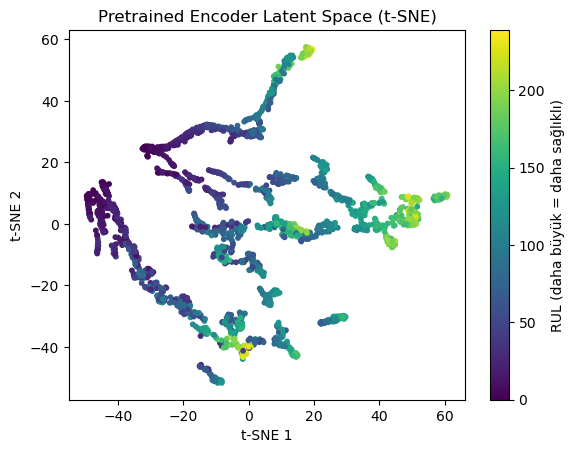

In [30]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Val setinden bir örneklem alalım (çok büyükse t-SNE yavaşlar)
SAMPLE_N = min(2000, X_va.shape[0])
idx = np.random.RandomState(42).choice(X_va.shape[0], size=SAMPLE_N, replace=False)

X_vis = torch.tensor(X_va[idx], dtype=torch.float32).to(device)
rul_vis = y_va[idx]

# Pretrained modelden embedding (h) çıkar
reg_model.eval()
with torch.no_grad():
    h, _ = model(X_vis)              # model = pretrained encoder
    h_np = h.cpu().numpy()

# t-SNE 2 boyuta indir
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
h_2d = tsne.fit_transform(h_np)

plt.figure()
plt.scatter(h_2d[:, 0], h_2d[:, 1], c=rul_vis, s=10)
plt.colorbar(label="RUL (daha büyük = daha sağlıklı)")
plt.title("Pretrained Encoder Latent Space (t-SNE)")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.show()
